# Лекция 4. Графы.

> __Граф__ -  совокупностью объектов и линий их соединящих. Объекты обычно называются вершинами графа, а линии - ребрами.

<img src="graph.png">

Если добавить ребер графа добавить направление, то есть становится существенным как соединены вершины, то такой граф называется _ориентированым_, в противном случае - _неориентированым_.

<img src="digraph.png">

# Зачем?

С помощью графов удобно представлять различные задачи: парсинг выражений, 3D графика, построение маршрутов, теория игр, факторизация полной вероятности, нейронные сети и много другое.

<img src="comp.png">

<img src="https://karta-metro.ru/images/moscowMetroMap.gif">

# Представление

Графы полностью описываются множеством своих вершин и ребер. Таким образом, подходит любая структура, которая позволяет хранить эту информацию. Например
- матрица смежности
- дерево объектов

# Матрица смежности

Это один из простых способо задания графа. У нас имеется матрица $n$ на $n$, где номера столбцов и строк связаны с номером вершины. На пересечение столбцов и строк стоит значение связанное с ребром  между этими вершинами (в простейшем случае 1 - есть связь, 0 - нет связи).

<img src="simple.png">



```
  | 1| 2| 3| 4|
-- -- -- -- --
1 |  | 1|  |  |
-- -- -- -- --
2 | 1|  | 1| 1|
-- -- -- -- --
3 |  | 1|  |  |
-- -- -- -- --
4 |  | 1|  |  |
-- -- -- -- --
```

Даннный способ плохо подходит, если между вершинами может быть несколько ребер. В этом случае столбцы матрицы начинают обозначать номера вершин, а строки - номера ребер. 

# Дерево

Программно, очень удобно представлять граф в виде дерева связанных объектов

In [63]:
class Node:
    def __init__(self, name, parent=None):
        self.name = name
        self.parent = parent
        self.children = []
        if self.parent is not None:
            parent.children.append(self)
    
    def print(self, deep=0):
        print("\t"*deep, f'Node[{self.name}]')
        for child in self.children:
            child.print(deep + 1)
        
root = Node('root')

A = Node('A', root)
B = Node('B', root)

C = Node('C', A)
D = Node('D', A)
E = Node('E', A)

root.print()

 Node[root]
	 Node[A]
		 Node[C]
		 Node[D]
		 Node[E]
	 Node[B]


# Пример

Сделаем парсер простых выражений, который будет строить дерево вычислений, вида: `1 + (4 / 2)`

In [300]:
# Это нам нужно для генерации уникальных идентификаторов
from uuid import uuid4


class Node:
    """ Родительский класс для вершины вычислительного графа """
    def __init__(self, *, parent=None):
        self.children = []
        self.parent = None
        self.id = "ID_" + uuid4().hex
        
        if parent is not None:
            parent.add_child(self)
            
    def name(self):
        """ Имя узла """
        raise NotImplemented
            
    def add_child(self, node):
        """ Позволяет добавить к узлу потомка """
        self.children.append(node)
        node.parent = self
        
    def calc(self):
        """ Вычислить значение в узле """
        raise NotImplemented
            
    def dot(self):
        """ Формирование dot-файла """
        result = f'\t{self.id} [label="{self.name()}"]\n'
        
        for child in self.children:
            result += child.dot()
            result += f'\t{self.id} -- {child.id}\n'
        return result
    
    
class ConstNode(Node):
    """ Узел описывающий константы в выражениях """
    def __init__(self, value, *, parent=None):
        super().__init__()
        self.value = value
        
    def __repr__(self):
        return f'<ConstNode = {self.value}>'
    
    def calc(self):
        return self.value
    
    def name(self):
        return str(self.value)
    
    
class BinaryOpNode(Node):  
    """ Родительский узел для бинарных операторов """
    def _op(self, a, b):
        """ Сама операция, должна быть переопределена в потомках """
        raise NotImplemented
        
    def calc(self):
        assert len(self.children) == 2 
        return self._op(self.children[0].calc(), self.children[1].calc())
    
    def __repr__(self):
        return f'<{self.__class__.__name__}>'
    
class MinusNode(BinaryOpNode):
    def _op(self, a, b):
        return a - b
    
    def name(self):
        return "-"
    
class PlusNode(BinaryOpNode):
    def _op(self, a, b):
        return a + b
    def name(self):
        return "+"
    
class MultNode(BinaryOpNode):
    def _op(self, a, b):
        return a * b
    def name(self):
        return "*"

class DivNode(BinaryOpNode):
    def _op(self, a, b):
        return a / b
    def name(self):
        return "/"
    
class PowerNode(BinaryOpNode):
    def _op(self, a, b):
        return a ** b
    def name(self):
        return "^"
    
    
class UnaryOpNode(Node):
    """ Родительский класс для унарных операторов """
    def _op(self, a):
        raise NotImplemented
        
    def calc(self):
        assert len(self.children) == 1
        return self._op(self.children[0].calc())
    def __repr__(self):
        return f'<{self.__class__.__name__}>'
    
class UnaryMinusNode(UnaryOpNode):
    def _op(self, a):
        return -a
    def name(self):
        return "neg"
    
a = ConstNode(5)
b = ConstNode(7)
c = ConstNode(10)

op = MultNode()
op.add_child(a)
op.add_child(b)

op2 = MinusNode()
op2.add_child(op)
op2.add_child(c)

op2.calc()

25

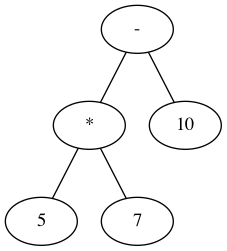

In [301]:
def render(node):
    """
        Отрисовка вычислительного графа в dot-файл
        Для рендера должен стоять пакет Graphviz (https://graphviz.org/)
        
        Работает только в Jupyter (из-за модуля display)
    """
    import os
    with open("test.dot", "w") as f:
        print("graph Example {", file=f)
        print(node.dot(), file=f)
        print("}", file=f)
        
    # вызов утилиты для рендера в png
    os.system("dot -Tpng -o test.png test.dot")
    from IPython.display import Image
    return Image(filename='test.png') 
    
render(op2)

# Обратная польская запись

Пока есть символы для чтения:
1. читаем следующий символ
   - если это число или постфиксная функция, то добавляем его к выводу
   - если это префиксная функция, то помещаем в стек
   - если это открывающая скобка, то помещаем в стек
   - если закрывающая скобка, то до тех пор, пока на вершине стека не окажется открывающая скобка, выталкиваем символы с вершины стека в вывод
   - если это бинарная операция, то
       1. пока на вершине стека префиксная функция, или операция приоритетней (или того же уровня приоритета) как у прочитанной бинарной операции - выталкиваем верхний элемент стека в вывод
       2. помещаем бинарную операцию в стек
2. Если строка закончилась, то выталкиваем все символы из стека в вывод, иначе к пункту 1


Надо отметить, что символ `-` является многозначным (он может быть унарным и бинарным оператором) и нужно учитывать предыдущий символ, чтобы понять убрать эту многозначность.

In [302]:
import re


def parse(s):
    binary = set(["+", "-", "*", "/", "^"])
    unary = set(["+", "-"])
    # список приоритетов операторов
    operators = {
        "+":   0, 
        "-":   0, 
        "*":   1, 
        "/":   1,
        "neg": 2, # унарный -
        "pos": 2, # унарный +
        "^":   3,
    }
    
    
    # убиваем пробельные символы
    s = re.subn(r'\s+', "", s)[0]
    
    # разбиваем на символы
    symbols = [
        groups[0] for groups in re.findall(r'(\d+(\.\d*)?|[()+*/^-])', s)
    ]
    tmp = []
    # фиксим литералы отрицательных чисел и положительных 
    # (если перед ними стоит знак + или -)
    i = 0
    while i < len(symbols):
        # если натыкаемся на + или - и следующим символом идет число
        if (i + 1 < len(symbols) 
            and symbols[i] in ["+", "-"] 
            and re.match(r'^\d+(\.\d*)?$', symbols[i + 1])
           ):
            # если у нас начало строки или стоит скобка, то
            # это литерал числа, а не унарный оператор
            if i == 0 or symbols[i-1] == "(":
                tmp.append(symbols[i] + symbols[i + 1])
                i += 2
                continue
        
        tmp.append(symbols[i])
        i += 1
    symbols = tmp      
    
    print()
    print(f'{s=}')
    print(f'{symbols=}')

    stack = []
    result = []
    for i, symbol in enumerate(symbols):
        # Если это целое число
        if re.match(r'^[+-]?\d+$', symbol):
            result.append(int(symbol))
        # Если это вещественное число
        elif re.match(r'^[+-]?\d+\.\d*$', symbol):
            result.append(float(symbol))
        # Если это префиксный минус (унарный)
        elif symbol == "-" and (i == 0 or symbols[i-1] == "("):
            stack.append("neg")
        # Если это префиксный плюс (унарный)
        elif symbol == "+" and (i == 0 or symbols[i-1] == "("):
            stack.append("pos")
        # Если это открывающая скобка
        elif symbol == "(":
            stack.append(symbol)
        # Если это закрывающая скубка
        elif symbol == ")":
            while stack:
                v = stack.pop()
                if v == "(":
                    break
                result.append(v)
        # Если это бинарный оператор
        elif symbol in operators:
            """
                Это обычная строка, которая нигде не участвует,
                но может быть использована, как многострочный комментарий
                
                У нас три группы приоритетов операторов
                  - максимальный (^, neg)
                  - средний (*, /)
                  - низкий (+, -)
            """
            
            while stack:
                # если на вершине не оператор, останавливаемся
                # можно добавить проверку на функции, если они будут добавлены
                if stack[-1] not in operators:
                    break
                    
                v = stack[-1]
                    
                psym = operators[symbol]
                pv   = operators[v]
                
                # если приоритет оператора в стеке больше приоритета
                # прочитанного символа
                if pv > psym:
                    result.append(stack.pop())
                    continue
                # если равны приоритеты и символ в стеке не ^,
                # так как это правоассоциативный оператор
                elif pv == psym and symbol != "^":
                    result.append(stack.pop())
                    continue
                    
                # В остальных случаях ничего не делаем
                break
            stack.append(symbol)
            
        # неизвестный символ
        else:
            raise Exception(symbol)
            
    # очищаем стек в результат
    while stack:
        result.append(stack.pop())

    return result
    
print(parse("2 ^ 3.3 * 4"))
print(parse("+2 ^ 3.3 ^ 4"))
print(parse("-2 ^ 2 ^ 4"))
print(parse("-(2) ^ 2 ^ 4"))
print(parse("2 + 1 * 3 ^ 1"))
print(parse("(2 + 2) * 2"))
print(parse("(-2 - 2) / 2"))


s='2^3.3*4'
symbols=['2', '^', '3.3', '*', '4']
[2, 3.3, '^', 4, '*']

s='+2^3.3^4'
symbols=['+2', '^', '3.3', '^', '4']
[2, 3.3, 4, '^', '^']

s='-2^2^4'
symbols=['-2', '^', '2', '^', '4']
[-2, 2, 4, '^', '^']

s='-(2)^2^4'
symbols=['-', '(', '2', ')', '^', '2', '^', '4']
[2, 2, 4, '^', '^', 'neg']

s='2+1*3^1'
symbols=['2', '+', '1', '*', '3', '^', '1']
[2, 1, 3, 1, '^', '*', '+']

s='(2+2)*2'
symbols=['(', '2', '+', '2', ')', '*', '2']
[2, 2, '+', 2, '*']

s='(-2-2)/2'
symbols=['(', '-2', '-', '2', ')', '/', '2']
[-2, 2, '-', 2, '/']


# Построение графа вычислений


s='-(2^10)/2+(-2)^(8/2)'
symbols=['-', '(', '2', '^', '10', ')', '/', '2', '+', '(', '-2', ')', '^', '(', '8', '/', '2', ')']
[2, 10, '^', 'neg', 2, '/', -2, 8, 2, '/', '^', '+']
-496.0


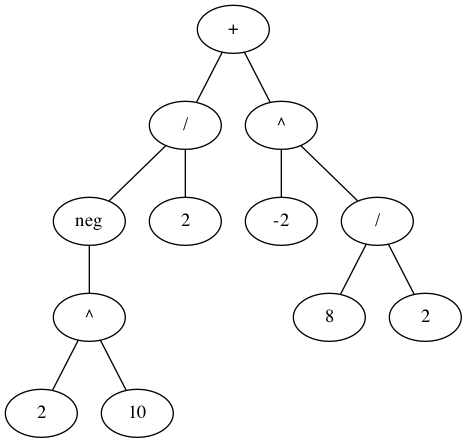

In [304]:
def make_tree(p):
    stack = []
    
    for s in p:
        if type(s) == float or type(s) == int:
            node = ConstNode(s)
            stack.append(node)
        elif s == "neg":
            a = stack.pop()
            op = UnaryMinusNode()
            op.add_child(a)
            stack.append(op)
        elif s in ["+", "-", "/", "*", "^"]:
            b = stack.pop()
            a = stack.pop()
            if s == "+":
                op = PlusNode()
            elif s == "-":
                op = MinusNode()
            elif s == "/":
                op = DivNode()
            elif s == "*":
                op = MultNode()
            elif s == "^":
                op = PowerNode()
            
            op.add_child(a)
            op.add_child(b)
            stack.append(op)
        else:
            raise Exception(s)

    return stack[0]

p = parse("-(2 ^ 10) / 2 + (-2) ^ (8/2)")
print(p)
root = make_tree(p)
print(root.calc())
render(root)